In [11]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pathlib import Path
from itertools import product

bids_root = str(Path.home()) + '/Documents/muniverse-data/Benchmarks/'

datasetnames = ['Caillet_et_al_2023', 'Grison_et_al_2025']

pipelinenames = ['cbss', 'scd']

global_rc = {pipeline: pd.DataFrame() for pipeline in pipelinenames}
source_rc = {pipeline: pd.DataFrame() for pipeline in pipelinenames}

for dataset in datasetnames:
    for pipeline in pipelinenames:
        path = bids_root + dataset + '-' + pipeline + '/'
        dataset_global_rc = pd.read_csv(path + 'report_card_globals.tsv', delimiter='\t')
        dataset_source_rc = pd.read_csv(path + 'report_card_sources.tsv', delimiter='\t')
        global_rc[pipeline] = pd.concat([global_rc[pipeline], dataset_global_rc], ignore_index=True)
        source_rc[pipeline] = pd.concat([source_rc[pipeline], dataset_source_rc], ignore_index=True)
       

In [12]:
dataset_of_interest = ['Caillet_et_al_2023', 'Grison_et_al_2025']

rows = [f"{d}-{a}" for d, a in product(dataset_of_interest, pipelinenames)]
columns = ['n_source', 'n_source_std', 'exp_var', 'exp_var_std','runtime', 'runtime_std']
summary = pd.DataFrame(np.nan, index=rows, columns=columns) 

sil_th = 0.9
cov_th = 0.3
min_num_spikes = 50

for dataset in dataset_of_interest:
    for pipeline in pipelinenames:
        row = f"{dataset}-{pipeline}"
        gdf = global_rc[pipeline].copy()
        gdf = gdf[(gdf['datasetname'] == dataset)]
        sdf = source_rc[pipeline].copy()
        sdf = sdf[(sdf['datasetname'] == dataset)]
        
        files = list(gdf['filename'])
        n_sources = np.zeros(len(files))
        for idx, file in enumerate(files):
            ssdf = sdf.copy()
            ssdf = sdf[(sdf['filename'] == file) & 
                       (sdf['sil'] > sil_th) & 
                       (sdf['cov_isi'] < cov_th) &
                       (sdf['n_spikes'] > min_num_spikes)]
            n_sources[idx] = ssdf.shape[0]

        summary.loc[row, 'n_source'] = np.mean(n_sources) 
        summary.loc[row, 'n_source_std'] = np.std(n_sources)   

        summary.loc[row, 'runtime'] = np.mean(gdf['runtime'])
        summary.loc[row, 'runtime_std'] = np.std(gdf['runtime'])
        summary.loc[row, 'exp_var'] = np.mean(gdf['explained_var'])
        summary.loc[row, 'exp_var_std'] = np.std(gdf['explained_var'])  

print(summary)          


                          n_source  n_source_std   exp_var  exp_var_std  \
Caillet_et_al_2023-cbss  23.363636     16.316599  0.481691     0.109800   
Caillet_et_al_2023-scd   29.909091     19.023691  0.520769     0.139722   
Grison_et_al_2025-cbss   20.800000      3.310589  0.285464     0.064131   
Grison_et_al_2025-scd    24.100000      3.700000  0.311510     0.074740   

                            runtime  runtime_std  
Caillet_et_al_2023-cbss  249.015442    52.217522  
Caillet_et_al_2023-scd   551.009691   240.735386  
Grison_et_al_2025-cbss   996.330297   406.720469  
Grison_et_al_2025-scd    828.232462   274.045200  


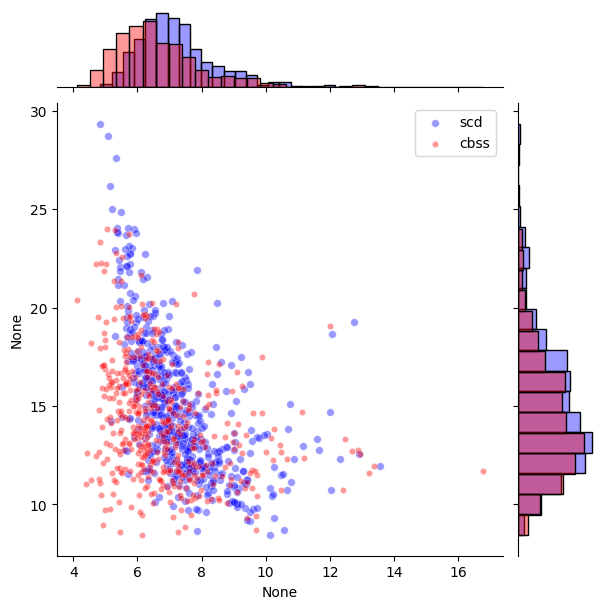

In [ ]:
import seaborn as sns

sdf = source_rc['scd'].copy()

sdf = sdf[(sdf['sil'] > sil_th) & 
          (sdf['cov_isi'] < cov_th) &
          (sdf['n_spikes'] > min_num_spikes)]

x1 = np.asarray(sdf['peak_height'])
y1 = np.asarray(sdf['mean_dr'])

sdf = source_rc['cbss'].copy()

sdf = sdf[(sdf['sil'] > sil_th) & 
          (sdf['cov_isi'] < cov_th) &
          (sdf['n_spikes'] > min_num_spikes)]

x2 = np.asarray(sdf['peak_height'])
y2 = np.asarray(sdf['mean_dr'])

# Create a JointGrid
g = sns.JointGrid(x=x1, y=y1)

# Plot first dataset
g.plot_joint(sns.scatterplot, color="blue", label="scd",s=30, alpha=0.4)
g.plot_marginals(sns.histplot, color="blue", alpha=0.4)

# Overlay second dataset
sns.scatterplot(x=x2, y=y2, color="red", ax=g.ax_joint, label="cbss", s=20, alpha=0.4)
sns.histplot(x=x2, color="red", ax=g.ax_marg_x, alpha=0.4)
sns.histplot(y=y2, color="red", ax=g.ax_marg_y, alpha=0.4)

# Add legend
g.ax_joint.legend()
g.ax_joint.set_xlabel("Spike amplitude")
g.ax_joint.set_ylabel("Mean firing rate (Hz)")

plt.show()